# Goal: To Predict the Trend in Gold Prices

## Analysis
This exercise analyses SPDR® Gold Shares (NYSE Arca : GLD). Prices of this share was downloaded from Yahoo Finance. 
Data spans from the inception of this share from 11/18/2004 to the date of download, 11/22/2019.

## Techniques Used
- EDA and visualize data
- Check If Time Series Data is Stationary using Dicky-Fuller Test
- Make the Time Series Data Stationary
- Use ACF and PACF to Choose the Model Order (AR, MA, ARMA)
- Use AIC and BIC Results to Pick the Optimal Model Order¶
- ARIMA Model with No Seasonality & One-Step Ahead Forecast
- Auto ARIMA Model with Seasonality & One-Step Ahead Forecast
- ARIMA Model with Seasonality & One-Step Ahead Forecast - Manual Grid Search
- Forecast using Training Data and Compare with the Test Data
- Conclusion

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pandas import DataFrame
import itertools
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

from math import sqrt
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error

# Analysis imports
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore') #this would remove any deprecated warning

# Load GLD All-Time Historical Dataset & Perform Some Analysis

SPDR® Gold Shares (NYSE Arca : GLD) - a cost-effective and convenient way to invest in gold

In [142]:
data_gld = pd.read_csv('data/gld.csv')
print("GLD Data: " + str(data_gld.shape))
data_gld.head()

GLD Data: (3780, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
1,2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2,2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
3,2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
4,2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100


In [143]:
data_gld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3780 entries, 0 to 3779
Data columns (total 7 columns):
Date         3780 non-null object
Open         3780 non-null float64
High         3780 non-null float64
Low          3780 non-null float64
Close        3780 non-null float64
Adj Close    3780 non-null float64
Volume       3780 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 206.8+ KB


In [144]:
data_gld.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3780.000000,3780.000000,3780.000000,3780.000000,3780.000000,3.780000e+03
mean,109.298553,109.854220,108.700423,109.297146,109.297146,9.677284e+06
std,33.461304,33.575604,33.326566,33.458163,33.458163,7.196708e+06
min,41.029999,41.360001,41.020000,41.259998,41.259998,3.193000e+05
25%,87.362501,88.407503,86.715000,87.419998,87.419998,5.089775e+06
50%,117.024998,117.444999,116.420002,116.985000,116.985000,7.992400e+06
75%,127.002500,127.532500,126.432501,127.127503,127.127503,1.205778e+07
max,184.580002,185.850006,182.100006,184.589996,184.589996,9.380420e+07


In [145]:
print("Dataframe contains GLD Data from from " + str(data_gld['Date'].min()) + " to " + str(data_gld['Date'].max()))

Dataframe contains GLD Data from from 2004-11-18 to 2019-11-22


# Visualize The Data

In [146]:
# Convert the date column from string to date and make it the index
dateparser = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data/gld.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparser)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100


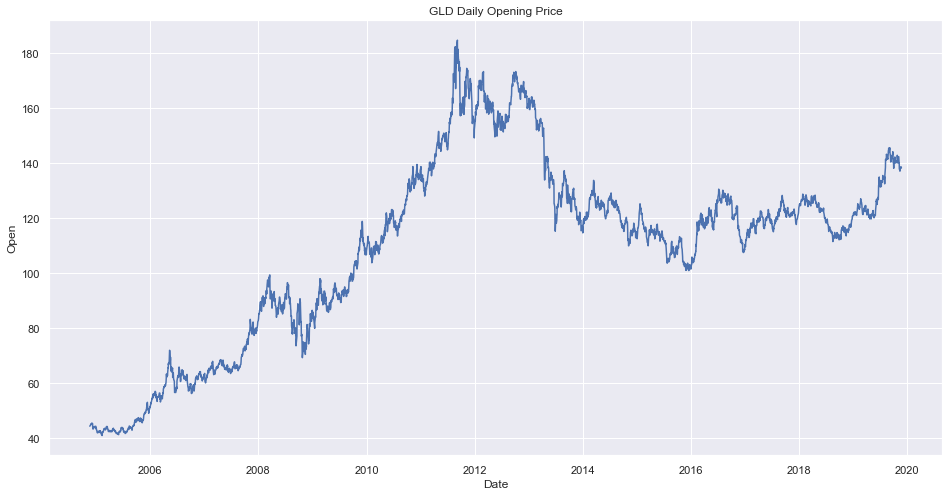

In [147]:
sns.set(style="darkgrid")
plt.figure(figsize=(16,8))
sns.lineplot(x=data.index, y='Open', data=data, linewidth=1.5).set_title('GLD Daily Opening Price')
plt.show()

# Check If Time Series Data is Stationary
Data needs to be stationary before modeling. Run Dicky-Fuller test on the Open Price

In [148]:
adfuller_result = adfuller(data['Open'])
print('ADF Statistic: ', adfuller_result[0])
print('p-value: ', adfuller_result[1])

ADF Statistic:  -1.798107909014194
p-value:  0.3814014680741159


### Conclusion: The data is not stationary because the p-value is greater than 0.05

# Make the Time Series Data Stationary
Use the difference method, square root and take the difference twice method to see which is a best way to make the data stationary

In [149]:
# Diff Method
data_diff = data.diff().dropna()
diff_adfuller_result = adfuller(data_diff['Open'])
print('Difference Method ADF Statistic: ', diff_adfuller_result[0])
print('Difference Method p-value: ', diff_adfuller_result[1])

Difference Method ADF Statistic:  -12.276741309059565
Difference Method p-value:  8.399233002207104e-23


In [150]:
data_sqrt = np.sqrt(data).dropna()
sqrt_adfuller_result = adfuller(data_sqrt['Open'])
print('Square Root Method ADF Statistic: ', sqrt_adfuller_result[0])
print('Square Root Methodp-value: ', sqrt_adfuller_result[1])

Square Root Method ADF Statistic:  -1.9628867402808488
Square Root Methodp-value:  0.3030791974103211


In [151]:
# Diff Twice Method
data_difftwice = data.diff().diff().dropna()
difftwice_adfuller_result = adfuller(data_difftwice['Open'])
print('Difference Method ADF Statistic: ', difftwice_adfuller_result[0])
print('Difference Method p-value: ', difftwice_adfuller_result[1])

Difference Method ADF Statistic:  -18.31591911444508
Difference Method p-value:  2.2710326109821816e-30


### Conclusion: Square Root method didn't produce a p-value less than 0.05. So we should eliminate this method. Between the both differencing methods, both produced a p-value less than 0.05. However, differencing twice produced a much more negative ADF statistic. This means the Differencing Twice Method is the best.

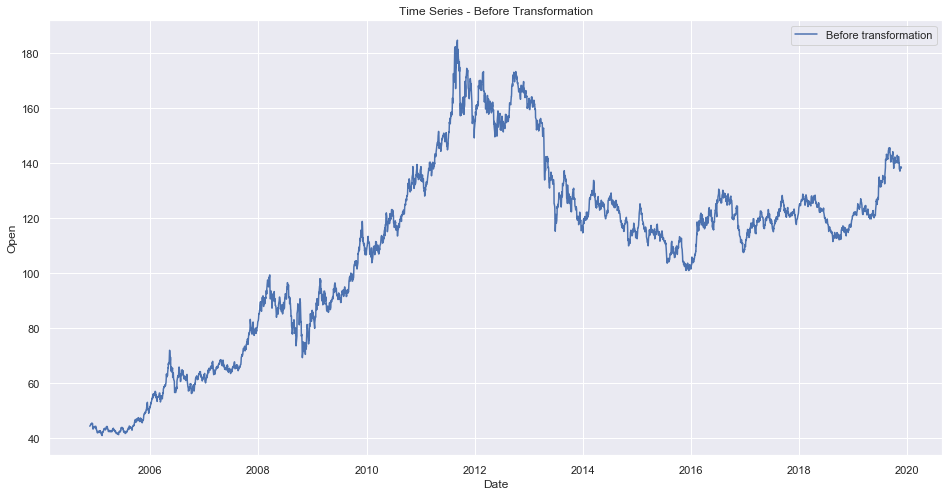

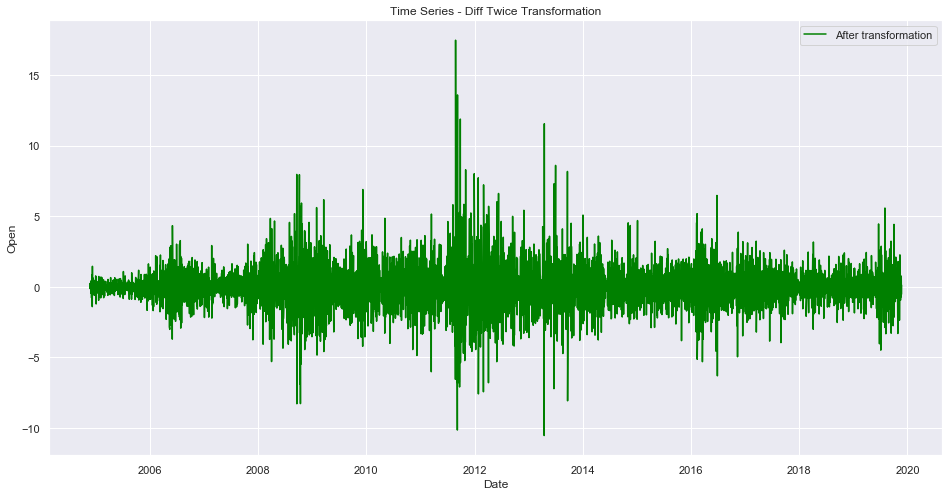

In [153]:
# Plot the time series before transformation
plt.figure(figsize=(16,8))
sns.lineplot(x=data.index, y='Open', data=data, linewidth=1.5, label='Before transformation').set_title('Time Series - Before Transformation')
plt.show()

# Plot the time series after transformation
plt.figure(figsize=(16,8))
sns.lineplot(x=data_difftwice.index, y='Open', data=data_difftwice, label='After transformation', color='green').set_title('Time Series - Diff Twice Transformation')
plt.show()

# Which Model - AR, MA or ARMA. Use ACF and PACF to Choose the Model Order

**ACF** - Autocorrelation function to help select the right order.

**PACF** - Partial Autocorrelation is the correlation between the time series and the lag version of itself after we subtract the effect of correlation at smaller lags.So, it’s just the correlation associated with just that particular lag

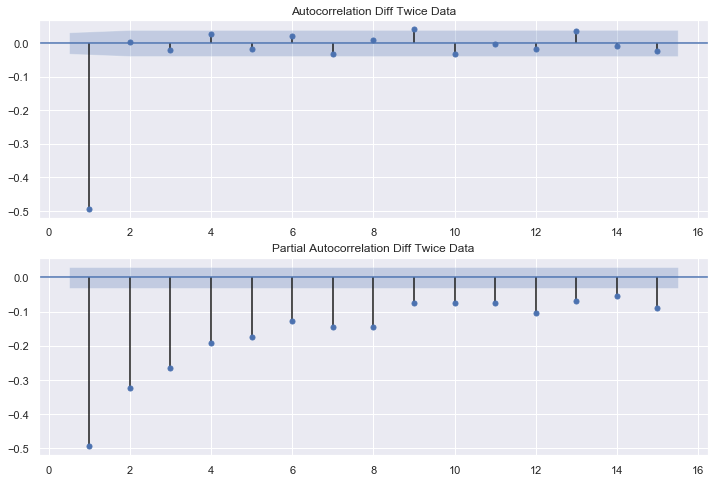

In [154]:
# Plot ACF and PACF with stationary data using data that was differenced twice

fig_difftwice, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF of data_difftwice
plot_acf(data_difftwice['Open'], lags=15, zero=False, ax=ax1, title='Autocorrelation Diff Twice Data')

# Plot PACF of data_difftwice
plot_pacf(data_difftwice['Open'], lags=15, zero=False, ax=ax2, title='Partial Autocorrelation Diff Twice Data')

plt.show()

ACF - Cuts off after lag 1

PACF - tails off

Initial conclusion: It may be a MA(1) model.

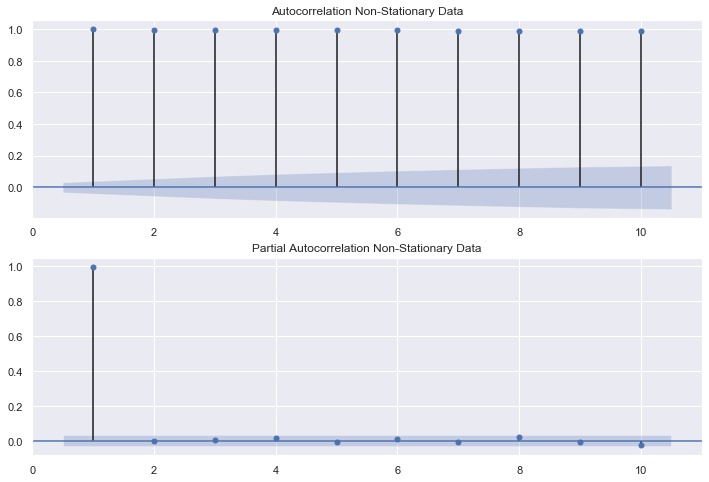

In [155]:
# Plot ACF and PACF with non-stationary data

fig_data_gld, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

# Plot ACF of data_difftwice
plot_acf(data_gld['Open'], lags=10, zero=False, ax=ax1, title='Autocorrelation Non-Stationary Data')

# Plot PACF of data_difftwice
plot_pacf(data_gld['Open'], lags=10, zero=False, ax=ax2, title='Partial Autocorrelation Non-Stationary Data')

plt.show()

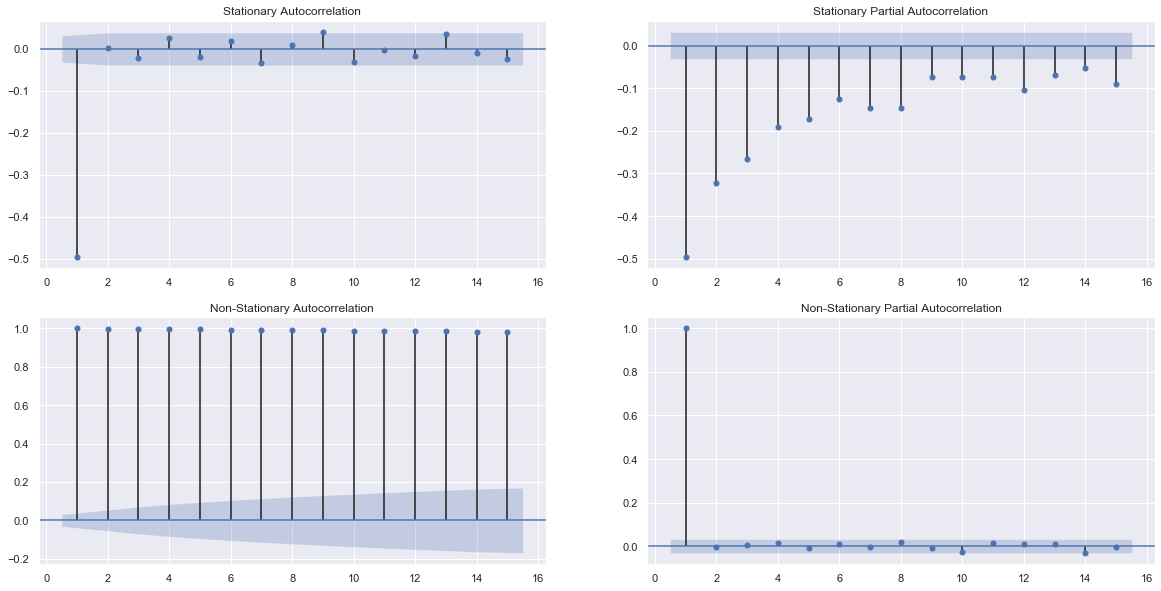

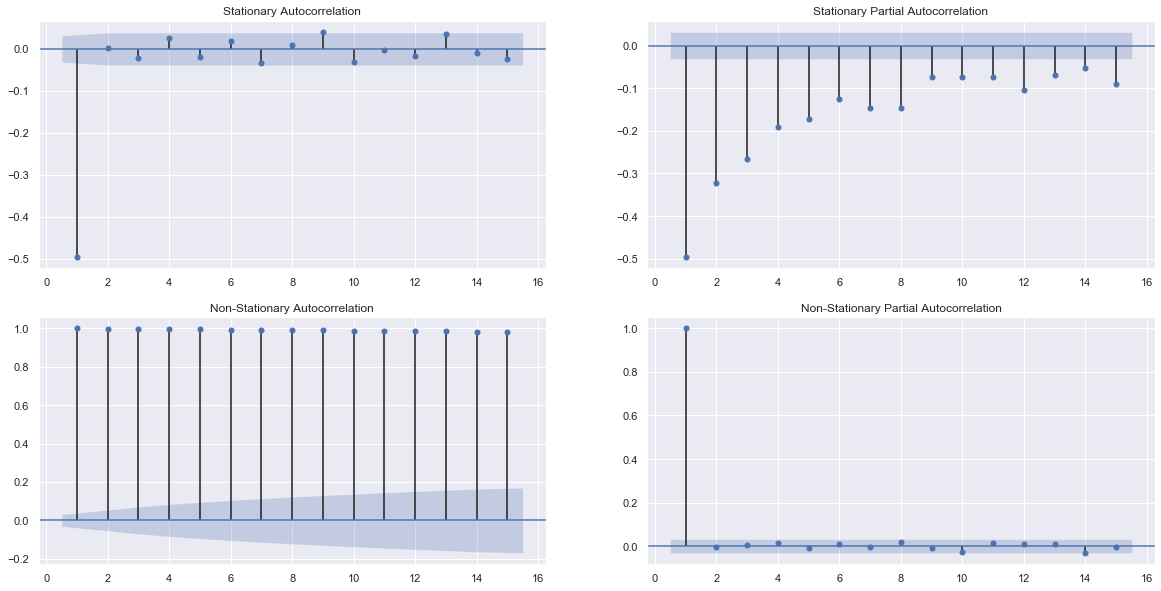

In [241]:
#Set the size of the entire plot
fig = plt.figure(figsize=[20,10])

# Plot ACF of data_difftwice
ax11 = fig.add_subplot(2, 2, 1)
plot_acf(data_difftwice['Open'], lags=15, zero=False, ax=ax11, title='Stationary Autocorrelation')

# Plot PACF of data_difftwice
ax22 = fig.add_subplot(2, 2, 2)
plot_pacf(data_difftwice['Open'], lags=15, zero=False, ax=ax22, title='Stationary Partial Autocorrelation')

# Plot ACF non-stationary data
ax33 = fig.add_subplot(2, 2, 3)
plot_acf(data_gld['Open'], lags=15, zero=False, ax=ax33, title='Non-Stationary Autocorrelation')

# Plot PACF non-stationary data
ax44 = fig.add_subplot(2, 2, 4)
plot_pacf(data_gld['Open'], lags=15, zero=False, ax=ax44, title='Non-Stationary Partial Autocorrelation')

#AONG Question - Not sure why the plots are repeating twice. It only happens when the last plot ax44 = fig.add_subplot(2, 2, 4) is run

# Conclusion
The **ACF** cuts off after lag 1 and the **PACF** tails off. This may indicate that a Moving Average Model with an order of 1 MA(1) might be the best. However, there are limitations to the ACF and PACF method. We are making the judgement based on how the ACF and PACF graphs look. Sometimes it may not be as clear to make a conclusion. 

Next, let's use a different method to pick the optimal model order - the AIC and BIC.

# Which Model - AR, MA or ARMA. Use AIC and BIC Results to Pick the Optimal Model Order

**Akaike Information Criterion (AIC)**
- Lower AIC indicates a better model
- AIC is ideal for simple models with lower order


**Bayesian Information Criterion (BIC)**
- Lower BIC indicated a better model
- BIC penalizes complex models

Most of the times, AIC and BIC will select the same model order. However, when they don't, we have to make a choice which to pick:
- AIC - better at choosing predictive models (use this if that’s our goal)
- BIC - better at choosing good explanatory model (use this if that’s our goal)



In [157]:
# Search for the ideal model order
order_aic_bic = []

# Loop over AR order
for p in range(3):
    # Loop over MA order
    for q in range(3):
        try:
            # Fit model
            model = SARIMAX(data_difftwice['Open'], order=(p,0,q))
            results = model.fit()
            # Store the model order and the AIC/BIC values in order_aic_bic list
            order_aic_bic.append((p, q, results.aic, results.bic))
            #print(p, q, results.aic, results.bic)
        except:
            # Print AIC and BIC as None when fails
            print(p, q, None, None)

In [158]:
# Make a dataframe of model order using AIC/BIC scores
aic_bic_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic', 'bic'])
print(aic_bic_df)

   p  q           aic           bic
0  0  0  14942.481354  14948.718304
1  0  1  12347.925302  12360.399202
2  0  2  12349.867556  12368.578407
3  1  0  13882.317903  13894.791803
4  1  1  12349.858505  12368.569355
5  1  2  12351.906442  12376.854242
6  2  0  13469.485530  13488.196380
7  2  1  12351.743467  12376.691267
8  2  2  12353.855373  12385.040123


In [159]:
# Sort by AIC
print(aic_bic_df.sort_values('aic'))

   p  q           aic           bic
1  0  1  12347.925302  12360.399202
4  1  1  12349.858505  12368.569355
2  0  2  12349.867556  12368.578407
7  2  1  12351.743467  12376.691267
5  1  2  12351.906442  12376.854242
8  2  2  12353.855373  12385.040123
6  2  0  13469.485530  13488.196380
3  1  0  13882.317903  13894.791803
0  0  0  14942.481354  14948.718304


In [161]:
# Sort by BIC
print(aic_bic_df.sort_values('bic'))

   p  q           aic           bic
1  0  1  12347.925302  12360.399202
4  1  1  12349.858505  12368.569355
2  0  2  12349.867556  12368.578407
7  2  1  12351.743467  12376.691267
5  1  2  12351.906442  12376.854242
8  2  2  12353.855373  12385.040123
6  2  0  13469.485530  13488.196380
3  1  0  13882.317903  13894.791803
0  0  0  14942.481354  14948.718304


# Conclusion: Both AIC and BIC selected the same p and q values of 0, 1.
This is the same results at the ACF and PACF analysis where we determined it was a MA(1) model order.

# Train-test Split
There are 15 years of data. We are going to use the first 12 years (2004 - 2016) as training data and the last 3 years (2017 - 2019) as test data.

In [162]:
train_data = data.loc[:'2016']
test_data = data.loc['2017':]

In [163]:
# Look at train data
train_data.shape

(3051, 6)

In [164]:
train_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100


In [165]:
train_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-23,107.839996,108.250000,107.800003,107.930000,107.930000,5012200
2016-12-27,108.610001,108.669998,108.239998,108.559998,108.559998,3685500
2016-12-28,108.400002,108.910004,108.290001,108.860001,108.860001,5091200
2016-12-29,109.230003,110.529999,109.160004,110.290001,110.290001,7563900
2016-12-30,110.379997,110.620003,109.529999,109.610001,109.610001,8873700


In [166]:
# Look at test data
test_data.shape

(729, 6)

In [167]:
test_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,109.620003,111.000000,109.370003,110.470001,110.470001,7527400
2017-01-04,111.059998,111.220001,110.610001,110.860001,110.860001,4904100
2017-01-05,112.160004,112.940002,112.070000,112.580002,112.580002,9606800
2017-01-06,111.809998,112.379997,111.570000,111.750000,111.750000,7686100
2017-01-09,112.389999,113.040001,112.180000,112.669998,112.669998,5674600


In [168]:
test_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-11-18,138.440002,138.850006,138.300003,138.619995,138.619995,5717900
2019-11-19,138.130005,138.970001,138.130005,138.690002,138.690002,4824400
2019-11-20,138.529999,139.000000,138.100006,138.759995,138.759995,6892100
2019-11-21,138.389999,138.559998,137.770004,138.000000,138.000000,4196500
2019-11-22,138.369995,138.460007,137.660004,137.740005,137.740005,3620300


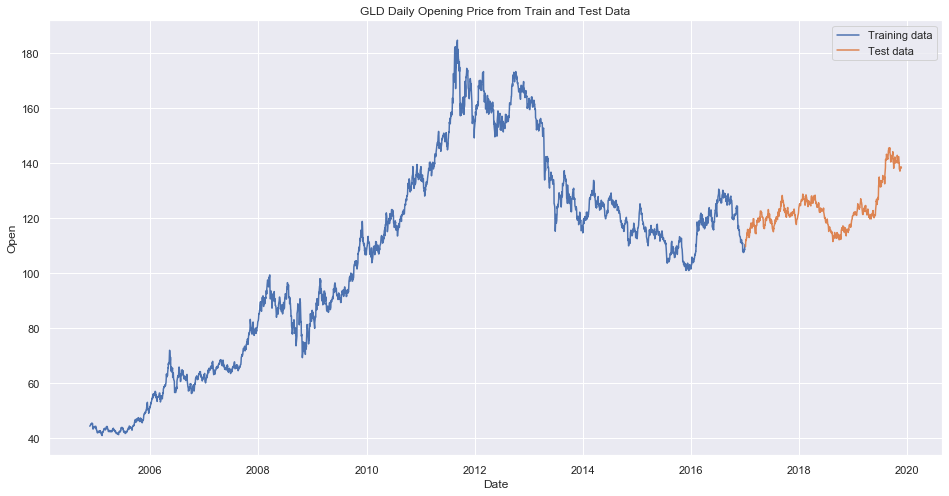

In [169]:
# Plot the test and train data
plt.figure(figsize=(16,8))
sns.lineplot(x=train_data.index, y='Open', data=train_data, linewidth=1.5, label='Training data').set_title('GLD Daily Opening Price from Train and Test Data')
sns.lineplot(x=test_data.index, y='Open', data=test_data, linewidth=1.5, label='Test data')
plt.show()

# Method 1: ARIMA Model with No Seasonality & One-Step Ahead Forecast

# Fit the Model With These Parameters
We start by comparing predicted values to real values of the time series, which will help us understand the accuracy of our forecasts.

When we forecast differenced time series, we end up with forecasted data of the difference. We have to use the difference to reverse engineer in order to derive the forecasted price. However, we can use ARIMA model to avoid all the work!

### ARIMA Model - Autoregressive Integrated Moving Average
model = SARIMAX(df, order = (p,d,q)
- p = number of autoregressive lags
- d = order of differencing
- q = number of moving average lags

Based on previous findings, the order = (p,d,q) should be:
- Difference = 2
- p = 0
- q = 1

When using ARIMA, the forecasted data is the actual forecated price, not the difference.

In [170]:
# Fit a model
model = SARIMAX(train_data['Open'], order=(0,2,1), trend= 'c')
results = model.fit()

# Make predictions for the last 300 days of the train data
# dynamic=False ensures we produce one-step ahead forecasts, forecasts at each point are generated using the full history up to that point
# start=-365, we want to start the prediction from one year back (365 days)
pred_365_traindata = results.get_prediction(start=-356, dynamic=False)

# Forecast mean for these 300 days
pred_mean_365_traindata = pred_365_traindata.predicted_mean

# Get confidence intervals of forecast
confidence_intervals = pred_365_traindata.conf_int()

# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Open']
upper_limits = confidence_intervals.loc[:,'upper Open']

In [171]:
print(pred_mean_365_traindata)

Date
2015-08-05    104.526024
2015-08-06    104.385941
2015-08-07    104.115812
2015-08-10    104.525939
2015-08-11    104.996095
                 ...    
2016-12-23    107.637474
2016-12-27    107.797499
2016-12-28    108.567746
2016-12-29    108.357647
2016-12-30    109.187911
Length: 356, dtype: float64


In [172]:
# Convert pred_mean_365_traindata series to a dataframe
# Inspect pred_mean_365_traindata_df
pred_mean_365_traindata_df = pred_mean_365_traindata.to_frame(name='forecasted_mean')
pred_mean_365_traindata_df.head()

,forecasted_mean
Date,
2015-08-05,104.526024
2015-08-06,104.385941
2015-08-07,104.115812
2015-08-10,104.525939
2015-08-11,104.996095


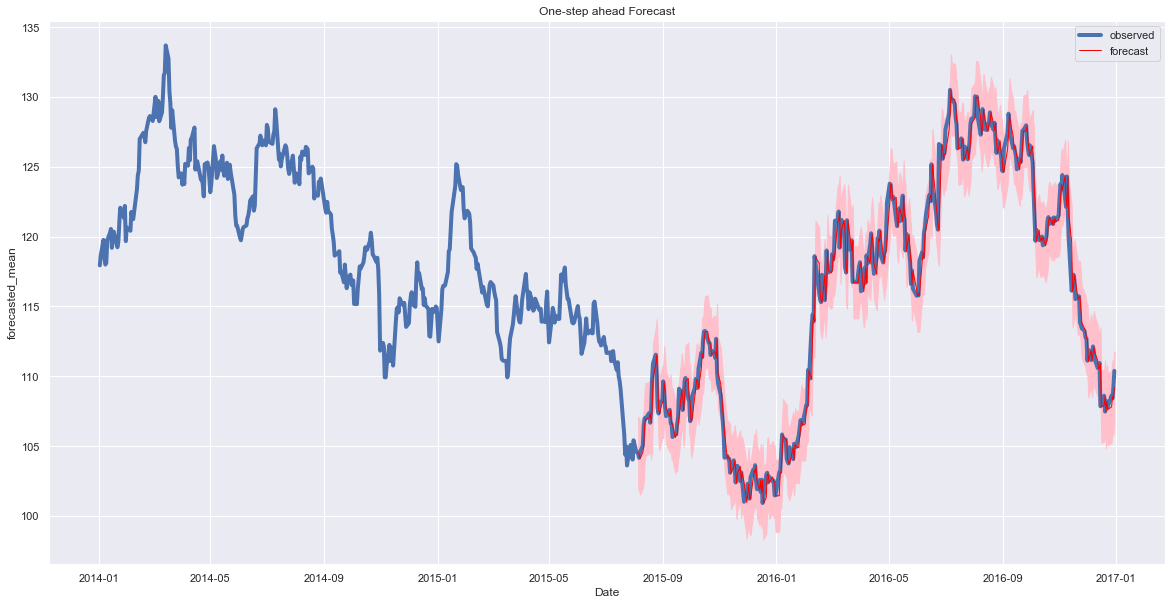

In [173]:
# Plot the origin test data - Zoom in starting from 2014
plt.figure(figsize=(20,10))
sns.lineplot(x=train_data['2014-01-01 00:00:00':].index, y='Open', data=train_data['2014-01-01 00:00:00':], linewidth=4, label='observed').set_title('One-step ahead Forecast')

# Plot the mean predictions
sns.lineplot(x=pred_mean_365_traindata_df.index, y=pred_mean_365_traindata_df['forecasted_mean'], data=pred_mean_365_traindata_df, linewidth=1, label='forecast', color='red')

# Shade the area between the confidence intervals
plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')


Overall, the above forecasts align with the true values very well for the last 365 days of the training data and it falls withing the confidence intervals.

# Method 1: Model Diagnostics
Evaluate the quality of the model before using it for forecasting in production.

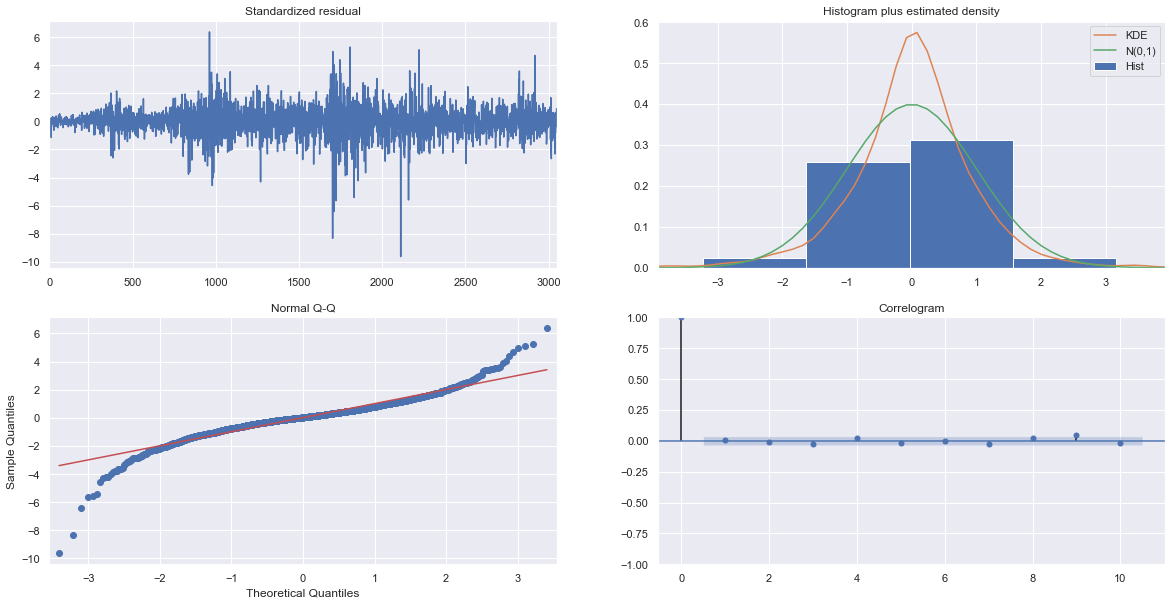

In [174]:
# Create the 4 diagnostic plots
results.plot_diagnostics()
plt.show()

In [175]:
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                   Open   No. Observations:                 3051
Model:               SARIMAX(0, 2, 1)   Log Likelihood               -5167.720
Date:                Mon, 25 Nov 2019   AIC                          10341.440
Time:                        11:08:12   BIC                          10359.508
Sample:                             0   HQIC                         10347.934
                               - 3051                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -4.151e-05      3e-05     -1.385      0.166      -0.000    1.72e-05
ma.L1         -0.9999      0.006   -167.102      0.000      -1.012      -0.988
sigma2         1.7297      0.024     72.942      0.0

# MAE, MSE, RMSE Calculations

- **Mean Absolute Error** - Measures the average magnitude of the errors in a set of forecasts, without considering their direction. It measures accuracy for continuous variables. Lower values are better, 0 is best.

- **Mean Squared Error (MSE)** - the average squared difference between the estimated values and what is estimated. Measures the quality of an estimator. Smaller the MSE, the closer we are finding the line of best fit.

- **Root Mean Square Error (RMSE)** - similar to MSE, however, the average squared difference between the estimated values and what is estimated. 

In [176]:
# Calculate Mean Absolute Error Between the Predicted Open Prices and the Real Open Prices
residuals = results.resid
mae = np.mean(np.abs(residuals))
print('The Mean Absolute Error of our forecasts is {}'.format(round(mae, 2)))

# Calculate Mean Square Error for periods 2015-08-05 to 2016-12-30 (last 365 days of training data)
pred_mean_365_traindata = pred_365_traindata.predicted_mean
real_values = train_data['2015-08-05':'2016-12-30']['Open']
mse = ((pred_mean_365_traindata - real_values) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Absolute Error of our forecasts is 0.92
The Mean Squared Error of our forecasts is 1.31
The Root Mean Squared Error of our forecasts is 1.15


In [177]:
# Shortcut - Use sklearn metrics library to calculate these metrics.
print('MAE: {}'.format(mean_absolute_error(real_values, pred_mean_365_traindata)))
print('MSE: {}'.format(mean_squared_error(real_values, pred_mean_365_traindata)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(real_values, pred_mean_365_traindata))))

MAE: 0.8578132724601739
MSE: 1.3149801279550395
RMSE: 1.1467258294618812


# Method 1: ARIMA Model with No Seasonality & One-Step Ahead Forecast

# Analysis of Diagnostic Results

### Real vs Forecated Value Plot
- the predicted values are align with the real values and the predicted values fall within the confidence interval


### Analysis from the 4 Diagnostic Plots
- **Standardized Residual Plot** - The graph doesn't seem to show a trend. That's what we want.
- **Historgram Plus Estimated Density** - This shows the distribution of the residuals. The green line shows a normal distribution and the orange line needs to be as close to the green line. The 2 lines are very different in this case. This model might need tweaking. 
- **Normal Q-Q** - This shows how the distribution of the residuals compares to a normal distribution. Most of the residuals are on the line except the ends.
- **Correlogram** - ACF plot of the residuals. 95% of the data where lag > 0 should not be significant. That means, they need to be within the blue shaded area. It looks like only 90% of the data is not significant. This model make not be the best fit.

### Analysis from Summary Results
- Ljung-Box - the null hypothesis states there are no correlations in the residual. If Prob(Q) <= 0.05, then we have to reject the null hypothesis and refit the model. In this case, it's 0.
- Jarque-Bera - the null hypothesis states the residual are normally distributed. If Prob(JB) <= 0.05, then we have to reject the null hypothesis and refit the model. In this case, it's 0.

### MAE, MSE, RMSE (use scklearn metrics)
- MAE: 0.86
- MSE: 1.31
- RMSE: 1.15 - our model forecasted the average daily open price in the test set is within $1.15 of the real open prices. This variance is too large.

### In Conclusion:
The analysis above shows that the residuals are correlated and they are not normally distrbuted. This means there is data that the model didn't capture. We need to refit the model. **We cannot use this model to make forecasts**.

# Seasonal Time Series
In the previous model, seasonality was not taken into account. Here's we'll investigate if the data is seasonal.

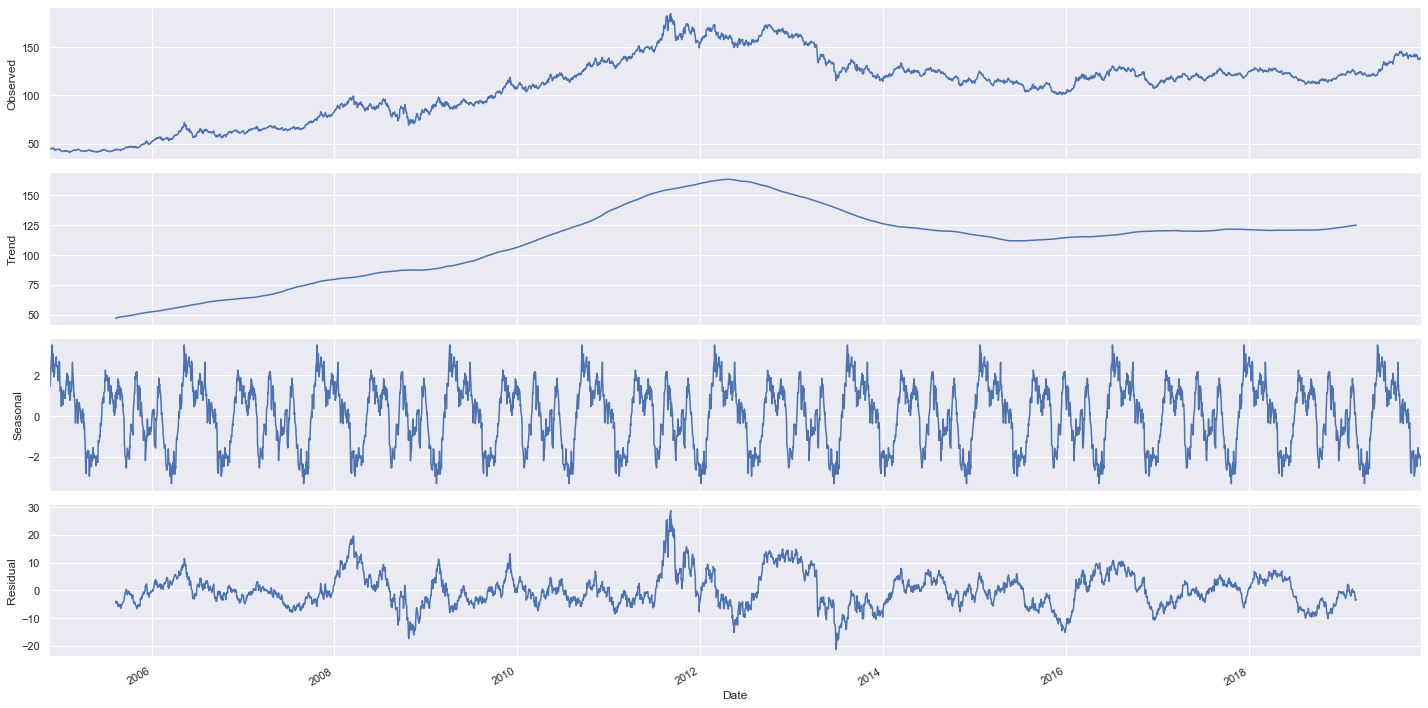

In [178]:
# Use seasonal_decompose to check for seasonal time series
# Additive = Level + Trend + Seasonality + Noise
# Used freq = 365 to represent 365 days in a year

decomp_results = seasonal_decompose(data['Open'], model='additive', freq=365)

# Visualize the data using time-series decomposition
decomp_results.plot()
plt.show()

The plots above shows that the trend in prices of gold is not consistent but there is some obvious seasonality.

# Fitting a SARIMA model with seasonal data

model = SARIMAX(df, order=(p,d,q), seasonal_order(P,D,Q,S))

**Non-seasonal order**
- p: autoregressive order
- d: differencing order
- q: moving average order

**Seasonal order**
- P: seasonal autoregressive order
- D: seasonaldifferencing order
- Q: seasonal moving average order
- S: number of time steps per cycle

# Method 2:  Auto ARIMA Model with Seasonality & One-Step Ahead Forecast

In [180]:
# In order to use Auto Arima (it's like an automatic grid search to discover the optimal order for an ARIMA model), data needs to be univariate series. We only need 1 column. 
# Source: http://www.alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html
arima_data = data.drop(columns=['High', 'Low', 'Close', 'Adj Close', 'Volume'])
arima_data.head()

,Open
Date,
2004-11-18,44.430000
2004-11-19,44.490002
2004-11-22,44.750000
2004-11-23,44.880001
2004-11-24,44.930000


In [181]:
# m = number of observations per seasonal cycle, 7-daily, 12-monthly, 52-weekly

results = auto_arima(arima_data,
                    seasonal=True,
                    #start_p = 1,
                    #start_q = 1,
                    #max_p = 3,
                    #max_q = 3,
                    #start_P=1,
                    #start_Q=1,
                    #max_P=3,
                    #max_Q=3,
                    m=7, #seasonal period
                    information_criterion='aic',
                    trace=True,
                    error_action='ignore',
                    stepwise=True)

Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 7); AIC=12338.982, BIC=12388.880, Fit time=8.791 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=12341.941, BIC=12354.415, Fit time=0.085 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=12343.712, BIC=12368.661, Fit time=0.496 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=12343.680, BIC=12368.629, Fit time=0.520 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 7); AIC=12335.604, BIC=12379.265, Fit time=6.407 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 7); AIC=12341.900, BIC=12379.323, Fit time=4.173 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 2, 7); AIC=12335.761, BIC=12385.659, Fit time=11.515 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 2, 7); AIC=12345.753, BIC=12401.888, Fit time=13.006 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 1, 7); AIC=12347.231, BIC=12384.655, Fit time=2.070 seconds
Fit ARIMA: order=

In [182]:
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                 3780
Model:             SARIMAX(2, 1, 2)x(0, 0, 1, 7)   Log Likelihood               -6160.802
Date:                           Mon, 25 Nov 2019   AIC                          12335.604
Time:                                   11:10:22   BIC                          12379.265
Sample:                                        0   HQIC                         12351.126
                                          - 3780                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1039      0.070      1.484      0.138      -0.033       0.241
ar.L1         -1.4986      0.030    -50.564

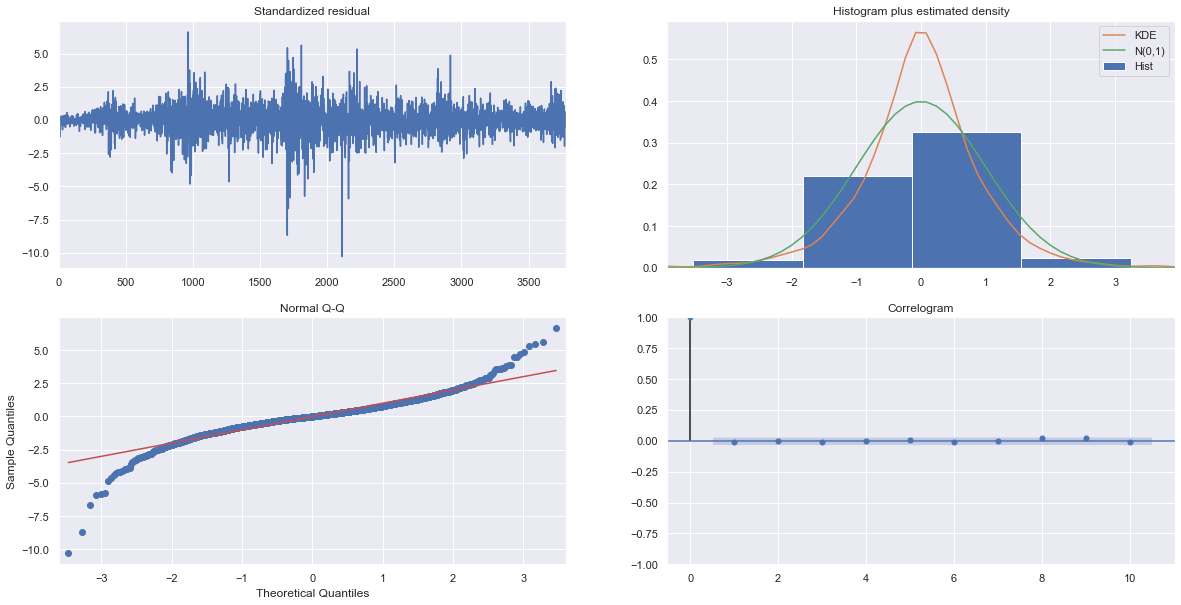

In [183]:
results.plot_diagnostics()
plt.show()

In [196]:
# Split data into training and test sets 
auto_arima_train_data = arima_data.loc[:'2016']
auto_arima_test_data = arima_data.loc['2017':]

# Create a model using auto arima
auto_arima_model = SARIMAX(auto_arima_train_data,
                    seasonal=True,
                    order=(2,1,2),
                    seasonal_order=(0,0,1,7),
                    trend='c')

# Fit the model
auto_arima_results = auto_arima_model.fit() 

# Make predictions for the last 365 days of the train data
# dynamic=False ensures we produce one-step ahead forecasts, forecasts at each point are generated using the full history up to that point
# start=-365, we want to start the prediction from one year back (365 days)
auto_arima_pred_365_traindata = auto_arima_results.get_prediction(start=-356, dynamic=False)

# Forecast mean for 365 days
auto_arima_pred_mean_365_traindata = auto_arima_pred_365_traindata.predicted_mean

# Get confidence intervals of forecast
auto_arima_confidence_intervals = auto_arima_pred_365_traindata.conf_int()

# Select lower and upper confidence limits
auto_arima_lower_limits = auto_arima_confidence_intervals.loc[:,'lower Open']
auto_arima_upper_limits = auto_arima_confidence_intervals.loc[:,'upper Open']

# Convert auto_arima_pred_mean_365_traindata series to a dataframe
# Inspect auto_arima_pred_mean_365_traindata_df
auto_arima_pred_mean_365_traindata_df = auto_arima_pred_mean_365_traindata.to_frame(name='forecasted_mean')
auto_arima_pred_mean_365_traindata_df.head()

,forecasted_mean
Date,
2015-08-05,104.651407
2015-08-06,104.380883
2015-08-07,104.156619
2015-08-10,104.697880
2015-08-11,104.912741


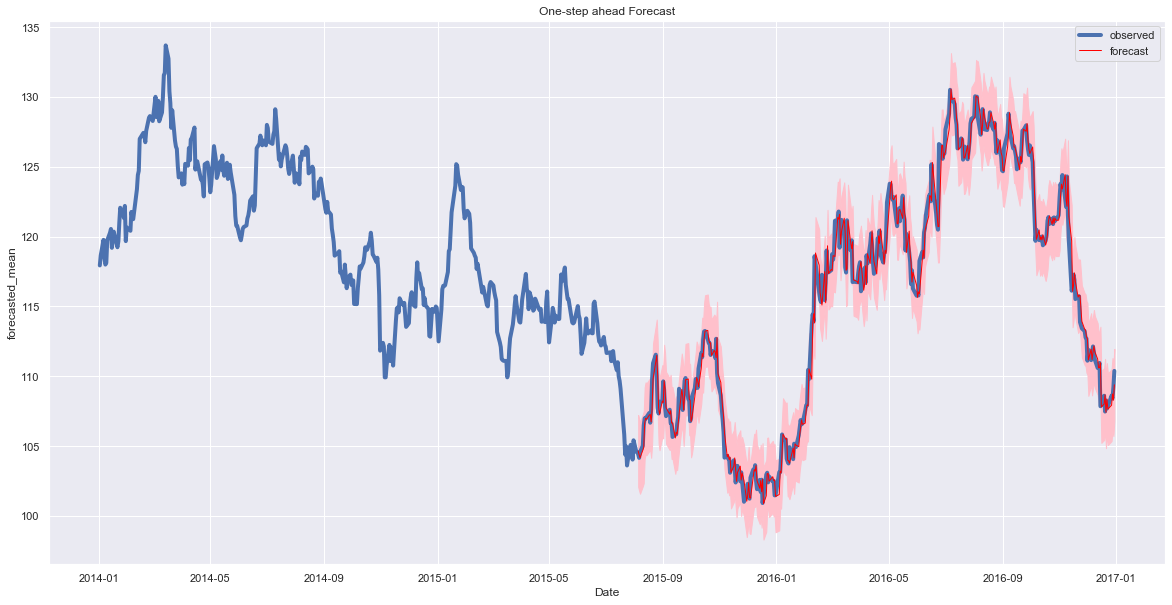

In [197]:
# Plot the origin test data - Zoom in starting from 2014
plt.figure(figsize=(20,10))
sns.lineplot(x=train_data['2014-01-01 00:00:00':].index, y='Open', data=train_data['2014-01-01 00:00:00':], linewidth=4, label='observed').set_title('One-step ahead Forecast')

# Plot the mean predictions
sns.lineplot(x=auto_arima_pred_mean_365_traindata_df.index, y=auto_arima_pred_mean_365_traindata_df['forecasted_mean'], data=auto_arima_pred_mean_365_traindata_df, linewidth=1, label='forecast', color='red')

# Shade the area between the confidence intervals
plt.fill_between(auto_arima_lower_limits.index, auto_arima_lower_limits, auto_arima_upper_limits, color='pink')

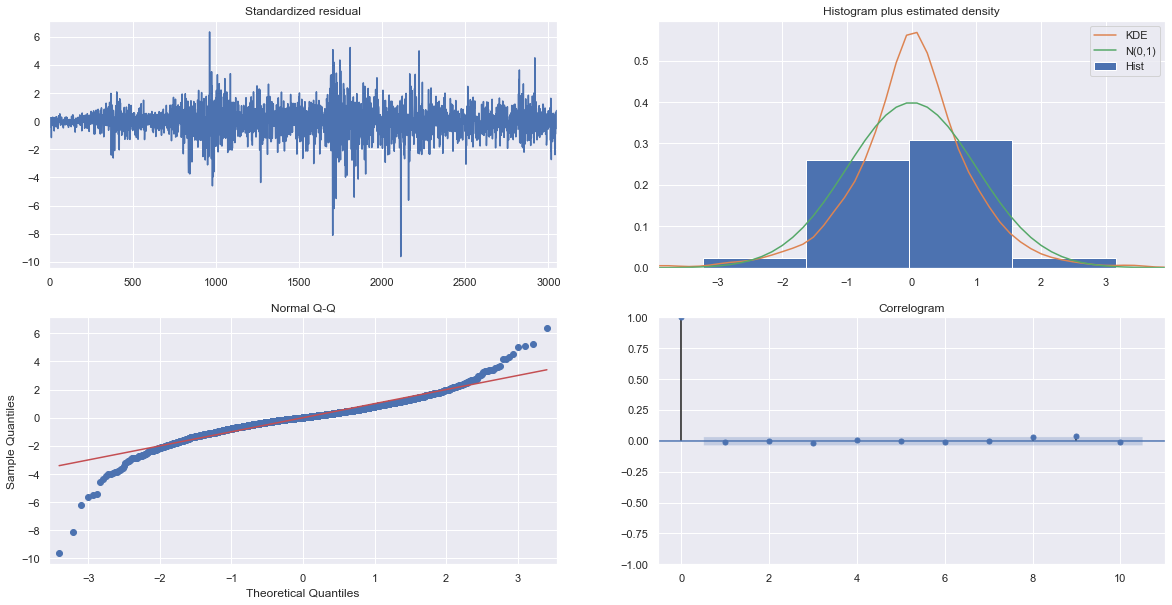

                                 Statespace Model Results                                
Dep. Variable:                              Open   No. Observations:                 3051
Model:             SARIMAX(2, 1, 2)x(0, 0, 1, 7)   Log Likelihood               -5155.643
Date:                           Mon, 25 Nov 2019   AIC                          10325.286
Time:                                   11:37:11   BIC                          10367.447
Sample:                                        0   HQIC                         10340.439
                                          - 3051                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0753      0.084      0.901      0.367      -0.088       0.239
ar.L1         -1.5203      0.011   -143.848

In [200]:
# Create the 4 diagnostic plots
auto_arima_results.plot_diagnostics()
plt.show()

# Print the diagnostic summary results
print(auto_arima_results.summary())

# Calculate MAE, MSE, RMSE
print('MAE: {}'.format(mean_absolute_error(real_values, auto_arima_pred_mean_365_traindata)))
print('MSE: {}'.format(mean_squared_error(real_values, auto_arima_pred_mean_365_traindata)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(real_values, auto_arima_pred_mean_365_traindata))))

# Method 2: ARIMA Model with Seasonality & One-Step Ahead Forecast - Using Auto_Arima to do Grid Search

## Analysis of Diagnostic Results

**Method 1:**
- MAE: 0.86
- MSE: 1.31
- RMSE: 1.15


**Method 2:**
- MAE: 0.85
- MSE: 1.31
- RMSE: 1.14

**Conclusion:** Method 2 of RMSE performed slightly better than Method 1

# Method 3: ARIMA Model with Seasonality & One-Step Ahead Forecast - Manual Grid Search

In [201]:
# Create a manual grid search
# DO NOT RUN THE FOLLOW 2 CELLS. IT TAKES ABOUT 1.5 HOURS TO RUN THE GRID SEARCH.
# GRID SEARCH RESULTS ARE STORED IN /data/arima_gridsearch_results.xls

#------- DO NOT UNCOMMENT UNLESS YOU WANT TO SPEND 1.5 HRS RUNNING THE GRID SEARCH -------#
#p = d = q = range(0, 3)
#pdq = list(itertools.product(p, d, q))
#seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

#print('Examples of parameter combinations for Seasonal ARIMA...')
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
#print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
#print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 0, 2, 7)
SARIMAX: (0, 0, 2) x (0, 1, 0, 7)
SARIMAX: (0, 0, 2) x (0, 1, 1, 7)


In [202]:
#------- DO NOT UNCOMMENT UNLESS YOU WANT TO SPEND 1.5 HRS RUNNING THE GRID SEARCH -------#
# THE OPTIMAL PARAMTERS FOUND BY THE GRID SEARCH IS => ARIMA(2, 1, 2)x(0, 0, 2, 7)7 - AIC:12298.183421032392

#for param in pdq:
#    for param_seasonal in seasonal_pdq:
#        try:
#            model_test = SARIMAX(arima_data, order=param,
#                                seasonal_order=param_seasonal,
#                                enforce_stationarity=False,
#                                enforce_invertibility=False,
#                                trace=True,
#                                error_action='ignore',
#                                stepwise=True,
#                                seasonal=True)

#            results = model_test.fit()

#            print('ARIMA{}x{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
            
#        except:
#            continue


ARIMA(0, 0, 0)x(0, 0, 0, 7)7 - AIC:46543.54021065851
ARIMA(0, 0, 0)x(0, 0, 1, 7)7 - AIC:41417.47310359836
ARIMA(0, 0, 0)x(0, 0, 2, 7)7 - AIC:36969.7693000034
ARIMA(0, 0, 0)x(0, 1, 0, 7)7 - AIC:19589.68925586988
ARIMA(0, 0, 0)x(0, 1, 1, 7)7 - AIC:19560.392055328266
ARIMA(0, 0, 0)x(0, 1, 2, 7)7 - AIC:19531.41076676208
ARIMA(0, 0, 0)x(0, 2, 0, 7)7 - AIC:22239.996228307216
ARIMA(0, 0, 0)x(0, 2, 1, 7)7 - AIC:19559.575022488716
ARIMA(0, 0, 0)x(0, 2, 2, 7)7 - AIC:19527.75551634886
ARIMA(0, 0, 0)x(1, 0, 0, 7)7 - AIC:19592.872519256536
ARIMA(0, 0, 0)x(1, 0, 1, 7)7 - AIC:19588.95100878088
ARIMA(0, 0, 0)x(1, 0, 2, 7)7 - AIC:19560.452469039
ARIMA(0, 0, 0)x(1, 1, 0, 7)7 - AIC:19564.855044780597
ARIMA(0, 0, 0)x(1, 1, 1, 7)7 - AIC:19562.391833242018
ARIMA(0, 0, 0)x(1, 1, 2, 7)7 - AIC:19526.67010721875
ARIMA(0, 0, 0)x(1, 2, 0, 7)7 - AIC:21101.817674065533
ARIMA(0, 0, 0)x(1, 2, 1, 7)7 - AIC:19560.340997226427
ARIMA(0, 0, 0)x(1, 2, 2, 7)7 - AIC:19530.391581602405
ARIMA(0, 0, 0)x(2, 0, 0, 7)7 - AIC:19563

ARIMA(0, 1, 2)x(2, 0, 0, 7)7 - AIC:12313.336783773384
ARIMA(0, 1, 2)x(2, 0, 1, 7)7 - AIC:12315.274361016467
ARIMA(0, 1, 2)x(2, 0, 2, 7)7 - AIC:12309.857588474439
ARIMA(0, 1, 2)x(2, 1, 0, 7)7 - AIC:13431.643242034046
ARIMA(0, 1, 2)x(2, 1, 1, 7)7 - AIC:12332.034792022416
ARIMA(0, 1, 2)x(2, 1, 2, 7)7 - AIC:12325.292845684198
ARIMA(0, 1, 2)x(2, 2, 0, 7)7 - AIC:15784.961045246024
ARIMA(0, 1, 2)x(2, 2, 1, 7)7 - AIC:13459.629984588737
ARIMA(0, 1, 2)x(2, 2, 2, 7)7 - AIC:12414.870112316434
ARIMA(0, 2, 0)x(0, 0, 0, 7)7 - AIC:14939.513531073586
ARIMA(0, 2, 0)x(0, 0, 1, 7)7 - AIC:14916.481757215177
ARIMA(0, 2, 0)x(0, 0, 2, 7)7 - AIC:14895.333377668256
ARIMA(0, 2, 0)x(0, 1, 0, 7)7 - AIC:17652.040679127123
ARIMA(0, 2, 0)x(0, 1, 1, 7)7 - AIC:14931.612422406268
ARIMA(0, 2, 0)x(0, 1, 2, 7)7 - AIC:14907.873557499202
ARIMA(0, 2, 0)x(0, 2, 0, 7)7 - AIC:21787.747651094185
ARIMA(0, 2, 0)x(0, 2, 1, 7)7 - AIC:17640.039663430478
ARIMA(0, 2, 0)x(0, 2, 2, 7)7 - AIC:14984.064435541379
ARIMA(0, 2, 0)x(1, 0, 0, 7)7

ARIMA(1, 0, 2)x(1, 0, 0, 7)7 - AIC:12330.6888592196
ARIMA(1, 0, 2)x(1, 0, 1, 7)7 - AIC:12327.9690698028
ARIMA(1, 0, 2)x(1, 0, 2, 7)7 - AIC:12312.088013986318
ARIMA(1, 0, 2)x(1, 1, 0, 7)7 - AIC:13701.401142962877
ARIMA(1, 0, 2)x(1, 1, 1, 7)7 - AIC:12342.771813223953
ARIMA(1, 0, 2)x(1, 1, 2, 7)7 - AIC:12325.434698911384
ARIMA(1, 0, 2)x(1, 2, 0, 7)7 - AIC:16531.398066997746
ARIMA(1, 0, 2)x(1, 2, 1, 7)7 - AIC:13721.161669914181
ARIMA(1, 0, 2)x(1, 2, 2, 7)7 - AIC:12414.134851288105
ARIMA(1, 0, 2)x(2, 0, 0, 7)7 - AIC:13699.297328718132
ARIMA(1, 0, 2)x(2, 0, 1, 7)7 - AIC:12317.304982828558
ARIMA(1, 0, 2)x(2, 0, 2, 7)7 - AIC:12315.02826184766
ARIMA(1, 0, 2)x(2, 1, 0, 7)7 - AIC:13302.810530955288
ARIMA(1, 0, 2)x(2, 1, 1, 7)7 - AIC:12330.908950076879
ARIMA(1, 0, 2)x(2, 1, 2, 7)7 - AIC:12327.449271600402
ARIMA(1, 0, 2)x(2, 2, 0, 7)7 - AIC:15532.268462053551
ARIMA(1, 0, 2)x(2, 2, 1, 7)7 - AIC:13329.982076171273
ARIMA(1, 0, 2)x(2, 2, 2, 7)7 - AIC:12420.126774329
ARIMA(1, 1, 0)x(0, 0, 0, 7)7 - AIC:1

ARIMA(1, 2, 2)x(0, 0, 0, 7)7 - AIC:12343.620613592986
ARIMA(1, 2, 2)x(0, 0, 1, 7)7 - AIC:12327.330517298169
ARIMA(1, 2, 2)x(0, 0, 2, 7)7 - AIC:12311.474932596695
ARIMA(1, 2, 2)x(0, 1, 0, 7)7 - AIC:15027.927379348763
ARIMA(1, 2, 2)x(0, 1, 1, 7)7 - AIC:12356.627456540675
ARIMA(1, 2, 2)x(0, 1, 2, 7)7 - AIC:12340.760385534162
ARIMA(1, 2, 2)x(0, 2, 0, 7)7 - AIC:18736.587578477585
ARIMA(1, 2, 2)x(0, 2, 1, 7)7 - AIC:14783.665439588623
ARIMA(1, 2, 2)x(0, 2, 2, 7)7 - AIC:12476.043208590203
ARIMA(1, 2, 2)x(1, 0, 0, 7)7 - AIC:12332.845313424594
ARIMA(1, 2, 2)x(1, 0, 1, 7)7 - AIC:12329.325172847472
ARIMA(1, 2, 2)x(1, 0, 2, 7)7 - AIC:12313.45904538029
ARIMA(1, 2, 2)x(1, 1, 0, 7)7 - AIC:13741.540012795864
ARIMA(1, 2, 2)x(1, 1, 1, 7)7 - AIC:12363.49010422891
ARIMA(1, 2, 2)x(1, 1, 2, 7)7 - AIC:12339.138554842844
ARIMA(1, 2, 2)x(1, 2, 0, 7)7 - AIC:16589.52249081243
ARIMA(1, 2, 2)x(1, 2, 1, 7)7 - AIC:13833.610260275467
ARIMA(1, 2, 2)x(1, 2, 2, 7)7 - AIC:12974.178520963549
ARIMA(1, 2, 2)x(2, 0, 0, 7)7 - 

ARIMA(2, 1, 1)x(2, 0, 0, 7)7 - AIC:12310.399582293681
ARIMA(2, 1, 1)x(2, 0, 1, 7)7 - AIC:12312.337504633317
ARIMA(2, 1, 1)x(2, 0, 2, 7)7 - AIC:12313.91301640018
ARIMA(2, 1, 1)x(2, 1, 0, 7)7 - AIC:13305.716388382572
ARIMA(2, 1, 1)x(2, 1, 1, 7)7 - AIC:12328.676381276846
ARIMA(2, 1, 1)x(2, 1, 2, 7)7 - AIC:12329.716663641884
ARIMA(2, 1, 1)x(2, 2, 0, 7)7 - AIC:15537.681406213957
ARIMA(2, 1, 1)x(2, 2, 1, 7)7 - AIC:13454.863816215042
ARIMA(2, 1, 1)x(2, 2, 2, 7)7 - AIC:12417.251046970727
ARIMA(2, 1, 2)x(0, 0, 0, 7)7 - AIC:12331.391569329357
ARIMA(2, 1, 2)x(0, 0, 1, 7)7 - AIC:12315.414397814859
ARIMA(2, 1, 2)x(0, 0, 2, 7)7 - AIC:12298.183421032392
ARIMA(2, 1, 2)x(0, 1, 0, 7)7 - AIC:14446.759025557925
ARIMA(2, 1, 2)x(0, 1, 1, 7)7 - AIC:12319.012844490893
ARIMA(2, 1, 2)x(0, 1, 2, 7)7 - AIC:12303.77240207902
ARIMA(2, 1, 2)x(0, 2, 0, 7)7 - AIC:18947.821293111083
ARIMA(2, 1, 2)x(0, 2, 1, 7)7 - AIC:14906.195922666591
ARIMA(2, 1, 2)x(0, 2, 2, 7)7 - AIC:12404.543479121006
ARIMA(2, 1, 2)x(1, 0, 0, 7)7 -

In [203]:
# Create a model using the optimal parameters found by the manual grid search: ARIMA(2, 1, 2)x(0, 0, 2, 7)7 - AIC:12298.183421032392
manual_arima_model = SARIMAX(auto_arima_train_data,
                    seasonal=True,
                    order=(2,1,2),
                    seasonal_order=(0,0,2,7),
                    trend='c')

# Fit the model
manual_arima_results = manual_arima_model.fit() 

# Make predictions for the last 365 days of the train data
# dynamic=False ensures we produce one-step ahead forecasts, forecasts at each point are generated using the full history up to that point
# start=-365, we want to start the prediction from one year back (365 days)
manual_arima_pred_365_traindata = manual_arima_results.get_prediction(start=-356, dynamic=False)

# Forecast mean for 365 days
manual_arima_pred_mean_365_traindata = manual_arima_pred_365_traindata.predicted_mean

# Get confidence intervals of forecast
manual_arima_confidence_intervals = manual_arima_pred_365_traindata.conf_int()

# Select lower and upper confidence limits
manual_arima_lower_limits = manual_arima_confidence_intervals.loc[:,'lower Open']
manual_arima_upper_limits = manual_arima_confidence_intervals.loc[:,'upper Open']

# Convert manual_arima_pred_mean_365_traindata series to a dataframe
# Inspect manual_arima_pred_mean_365_traindata_df
manual_arima_pred_mean_365_traindata_df = manual_arima_pred_mean_365_traindata.to_frame(name='forecasted_mean')
manual_arima_pred_mean_365_traindata_df.head()

,forecasted_mean
Date,
2015-08-05,104.661189
2015-08-06,104.399887
2015-08-07,104.216105
2015-08-10,104.725923
2015-08-11,104.951530


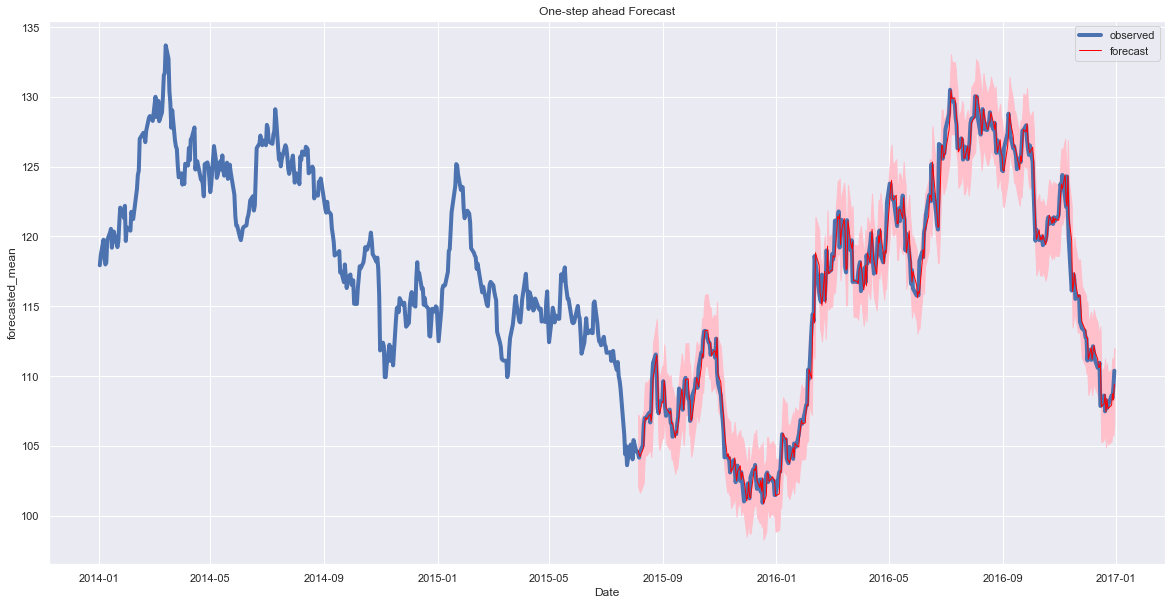

In [204]:
# Plot the origin test data - Zoom in starting from 2014
plt.figure(figsize=(20,10))
sns.lineplot(x=train_data['2014-01-01 00:00:00':].index, y='Open', data=train_data['2014-01-01 00:00:00':], linewidth=4, label='observed').set_title('One-step ahead Forecast')

# Plot the mean predictions
sns.lineplot(x=manual_arima_pred_mean_365_traindata_df.index, y=manual_arima_pred_mean_365_traindata_df['forecasted_mean'], data=manual_arima_pred_mean_365_traindata_df, linewidth=1, label='forecast', color='red')

# Shade the area between the confidence intervals
plt.fill_between(manual_arima_lower_limits.index, manual_arima_lower_limits, manual_arima_upper_limits, color='pink')

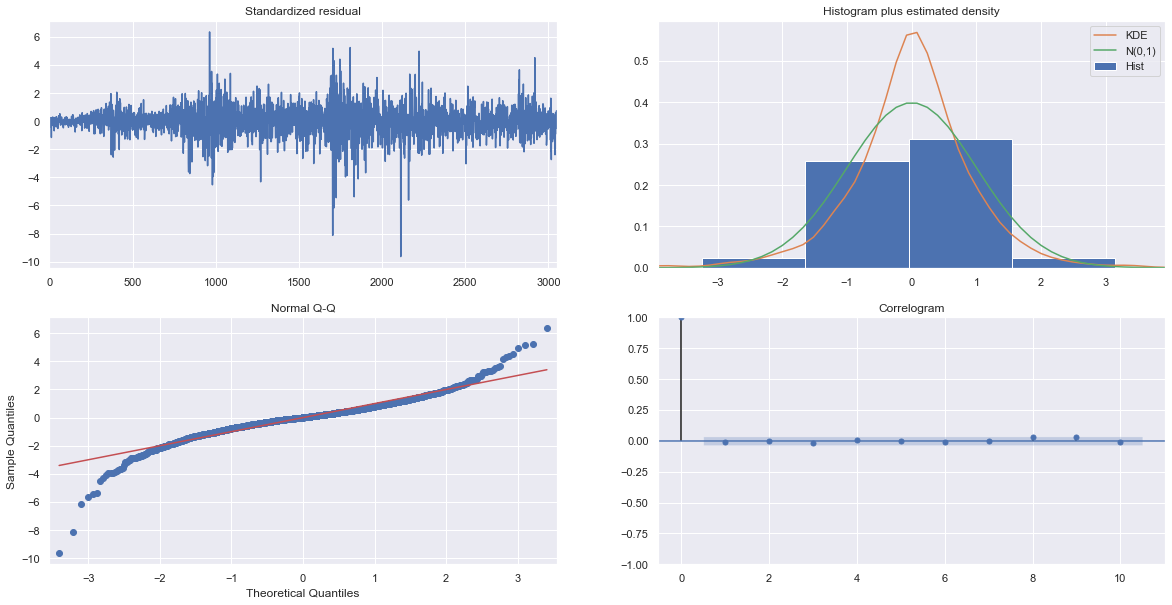

                                 Statespace Model Results                                
Dep. Variable:                              Open   No. Observations:                 3051
Model:             SARIMAX(2, 1, 2)x(0, 0, 2, 7)   Log Likelihood               -5154.624
Date:                           Mon, 25 Nov 2019   AIC                          10325.247
Time:                                   13:43:34   BIC                          10373.430
Sample:                                        0   HQIC                         10342.564
                                          - 3051                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0742      0.082      0.909      0.364      -0.086       0.234
ar.L1         -1.5161      0.011   -132.634

In [205]:
# Create the 4 diagnostic plots
manual_arima_results.plot_diagnostics()
plt.show()

# Print the diagnostic summary results
print(manual_arima_results.summary())

# Calculate MAE, MSE, RMSE
print('MAE: {}'.format(mean_absolute_error(real_values, manual_arima_pred_mean_365_traindata)))
print('MSE: {}'.format(mean_squared_error(real_values, manual_arima_pred_mean_365_traindata)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(real_values, manual_arima_pred_mean_365_traindata))))

# Method 3: ARIMA Model with Seasonality & One-Step Ahead Forecast - Using Manual Grid Search

## Analysis of Diagnostic Results

**Method 1:**
- MAE: 0.86
- MSE: 1.31
- RMSE: 1.15


**Method 2:**
- MAE: 0.85
- MSE: 1.31
- RMSE: 1.14
    
**Method 3:**
- MAE: 0.86
- MSE: 1.31
- RMSE: 1.14

**Conclusion:** Method 2 produced the lowest MAE and but had the same RMSE as Method 3. As such, we are going to use Method 2 for forecasting future data.

# Forecast using Training Data and Compare with the Test Data

In [235]:
# Forecasting out of the sample. Use 729 because that's how many days there are in the test set
auto_arima_forecast = auto_arima_results.get_forecast(steps=729)

# Forecast mean
auto_arima_mean_forecast = auto_arima_forecast.predicted_mean

# Get confidence intervals of forecast
# Assign it the same index at test data
auto_arima_forecasted_confidence_intervals = auto_arima_forecast.conf_int()
auto_arima_forecasted_confidence_intervals.index = test_data.index #need to do this in order to plot


# Select lower and upper confidence limits
auto_arima_forecasted_lower_limits = auto_arima_forecasted_confidence_intervals.loc[:,'lower Open']
auto_arima_forecasted_upper_limits = auto_arima_forecasted_confidence_intervals.loc[:,'upper Open']

# Convert auto_arima_mean_forecast to a dataframe
# Inspect auto_arima_mean_forecast
auto_arima_mean_forecast_df = auto_arima_mean_forecast.to_frame(name='forecasted_mean')
auto_arima_mean_forecast_df.index = test_data.index
auto_arima_mean_forecast_df.head()

,forecasted_mean
Date,
2017-01-03,110.382810
2017-01-04,110.340176
2017-01-05,110.478560
2017-01-06,110.376098
2017-01-09,110.449186


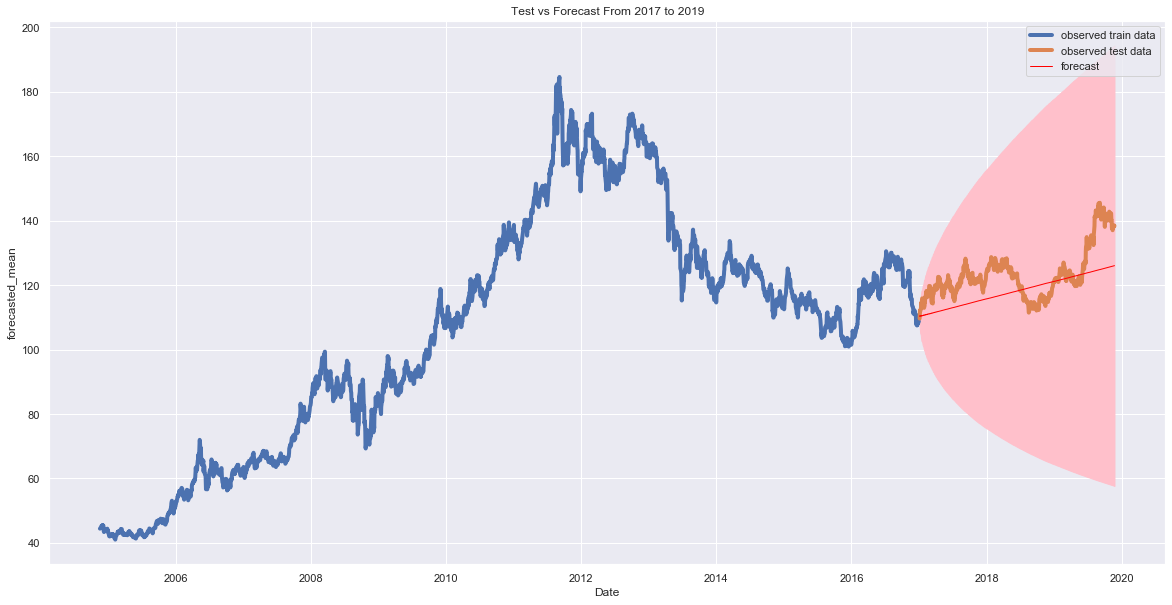

In [238]:
# Plot the forecasted data set against the test data
plt.figure(figsize=(20,10))

# Plot the train data
sns.lineplot(x=train_data.index, y='Open', data=train_data, linewidth=4, label='observed train data').set_title('Test vs Forecast From 2017 to 2019')

# Plot the test data
sns.lineplot(x=test_data.index, y='Open', data=test_data, linewidth=4, label='observed test data').set_title('Test vs Forecast From 2017 to 2019')

# Plot the forecast data
sns.lineplot(x=auto_arima_mean_forecast_df.index, y=auto_arima_mean_forecast_df['forecasted_mean'], data=auto_arima_mean_forecast_df, linewidth=1, label='forecast', color='red')

# Shade the area between the confidence intervals
plt.fill_between(auto_arima_forecasted_lower_limits.index, auto_arima_forecasted_lower_limits, auto_arima_forecasted_upper_limits, color='pink')

In [239]:
# Calculate MAE, MSE, RMSE
real_test_values = test_data['Open']

# Calculate MAE, MSE, RMSE
print('MAE: {}'.format(mean_absolute_error(real_test_values, auto_arima_mean_forecast)))
print('MSE: {}'.format(mean_squared_error(real_test_values, auto_arima_mean_forecast)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(real_test_values, auto_arima_mean_forecast))))

MAE: 6.797647600297153
MSE: 66.04606628389456
RMSE: 8.126873093871625


# Conclusion
By looking at the plot, the forecasted data showed an upward trend which is aligned with the test data. It correctely predicted that Gold Prices will go up from 2017 - 2019. It is also within the confidence interval, however the interval is really large. It's hard to predict the prices of gold but it's able to predict a general trend over time.